# Geometric Brownian Motion Simulation

In this notebook, we would simulate the stochastic differential equation for a Geometric Brownian Motion:

$\frac{dS}{S} = \mu dt + \sigma dW$

Where $W_t$ is a standard Brownian Motion/Wiener process such that:
$W(0) = 0.0$, $E[W_t] = 0.0$ and var[$W_t$] = t

The GBM is used frequently to simulate the evolution of stock prices because of some key reasons like, a. The price $S(t)$ never goes below 0, b. The returns follow a logarithmic distribution which matches approximately with historical data.

Here, we first obtain the intraday mean ($\mu$) and volatility ($\sigma$) of the returns from the historical data. These values are then plugged in the GBM equation. There are multiple ways to simulate the GBM equation. We explore two of these here: a. Simulating the analytic solution, b. Simulate the SDE using Euler-Maruyama method.  

### 1. The analytic solution:

$\frac{dS}{S} = \mu dt + \sigma dW_t$

Let $F(S) = log(S)$, according to Ito's lemma:

$dF = F_t dt + F_S dS + \frac{1}{2} F_{ss} dS.dS$

$F_t = 0$, $F_S = \frac{1}{S}$, $F_{ss} = \frac{-1}{S^2}$ and $dS.dS = (\mu dt + \sigma dW_t).(\mu dt + \sigma dW_t) =
\sigma ^2 S^2 dt$

Therefore, 

$dF = (\mu - \frac{\sigma^2}{2}) dt + \sigma dW_t$

$d(log(S)) = (\mu - \frac{\sigma^2}{2}) dt + \sigma dW_t$

$S(t) = e^{(\mu - \sigma^2/2)t + \sigma W_t}$

$\mathbb{E}(S_t) = S_0 e^{\mu t} $

$\mathbb{E}(log(S_t)) = log(S_0) + (\mu - \sigma^2/2)t$ 


$var(S_t) = S_0^2 e^{2 \mu t} (e^{\sigma^2 t} - 1)$


## Euler-Maruyama method:

Consider the SDE: $dS_t = a(S_t)dt + b(S_t)dW_t$ with $S_0 = s_0$ and where $W_t$ is the Wiener process.

The Euler-Maruyama approximation:

$S_{n+1} = S_n + a(S_n)\Delta t + b(S_n)\Delta W_n $

where $\Delta W_n = W_{\tau_{n+1}} - W_{\tau_{n}}$ are independent and i.i.d random normal variables with expected value 0 and variance $\Delta t$. 

Hence, $S(t) = S(t-1) + S(t-1)*(\mu dt + \sigma Z(0,1) \sqrt{dt})$



## Obtain historical drift and volatility

First we import the Adjusted Close Price from yahoo and obtain the historical mean and variance of the returns. We take Microsoft stock as an example. 

Two ways to obtain log returns:
1. log_returns = np.log(close_data/close_data.shift(1))
2. log_returns = np.log(1 + close_data.pct_change())       

pd.pct_change() obtains simple returns from a data set

In [2]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt


In [3]:
close_data = pd.DataFrame()
close_data['MSFT'] = wb.DataReader('MSFT', data_source='yahoo', start='2007-1-1')['Adj Close']

In [4]:
log_returns = np.log(1.0 + close_data.pct_change())

#Remove the NaN in the first row:

log_returns = log_returns.iloc[1:]

log_returns.head()

,MSFT
Date,
2007-01-04,-0.001676
2007-01-05,-0.005719
2007-01-08,0.009736
2007-01-09,0.001002
2007-01-10,-0.010064


### Plotting Closing Price and Log Returns

We next plot the closing price and the log returns. 

Text(0.5,0,'Log Returns')

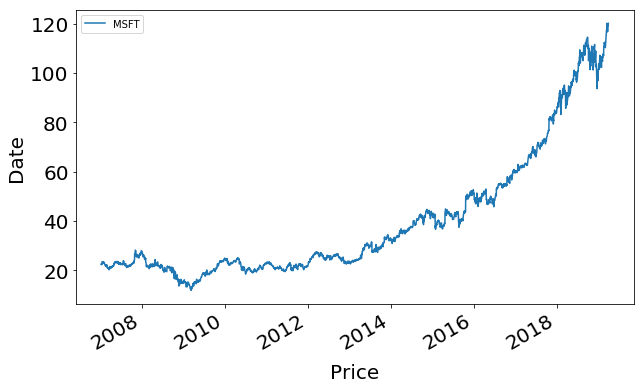

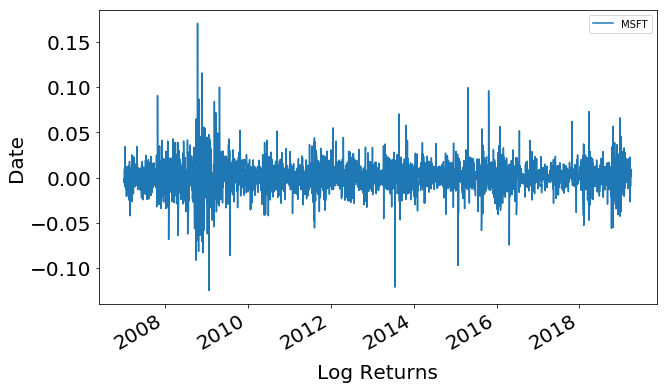

In [5]:
close_data.plot(fontsize = 20, figsize=(10,6))
plt.ylabel('Date', size = 20)
plt.xlabel('Price', size = 20, labelpad = 10)


log_returns.plot(fontsize = 20, figsize=(10,6))
plt.ylabel('Date', size = 20)
plt.xlabel('Log Returns', size = 20, labelpad = 10)

Next we check if indeed the log-returns are normally distributed. This serves as a simple sanity check and would help us realize that GBM approximation for stock prices can be quite off at times.

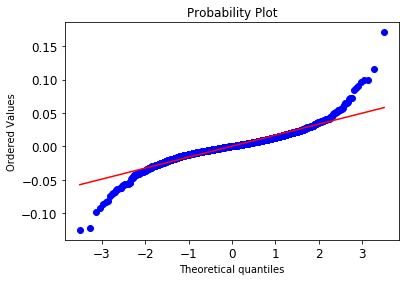

In [6]:
from scipy import stats

stats.probplot(log_returns['MSFT'], dist= "norm", plot=plt)
plt.tick_params(axis='both', labelsize= 12)


## Obtaining the historical mean, variance and drift of returns

drift = $\mu - \frac{\sigma^2}{2}$

In [7]:
mu = log_returns.mean().values            #the .mean method returns a Series. To work with these values later we need
sigma = log_returns.std().values          #the absolute values.
drift = mu - (sigma*sigma)/2.0
print(mu)
print(sigma)
print(drift)

[0.00054391]
[0.01718703]
[0.00039621]


These numbers are for the daily returns. It's important not to lose track of the units here. 

## Method One: Using the analytic solution:

$S(t) = S(0)\exp[{(\mu - \sigma^2/2) t + \sigma W_t}]$

We denote r as the array of daily returns
$r = \exp[{(\mu - \sigma^2/2) t + \sigma W_t}]$

$W_t$ follows a standard normal distribution

We simulate the daily returns and use the expression:

$S_{t+1} = S_t r_t$

where $r_t = \exp[{(\mu - \sigma^2/2) + \sigma W_t}]$

In [8]:
t_intervals = 250
t_iterations = 10000

In [9]:
r_array = np.exp(drift + sigma*np.random.normal(0,1,(t_intervals,t_iterations)))

S_0 = close_data.iloc[-1]   #We take the starting price as the last price from the historical data  

price_array = np.zeros_like(r_array) #We create an array of the price list: the columns are various iterations, 
                                    #the rows are the time series
price_array[0] = S_0
print(price_array)

[[120.23500061 120.23500061 120.23500061 ... 120.23500061 120.23500061
  120.23500061]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]


In [10]:
for t in range(1, t_intervals):
    price_array[t] = price_array[t-1]*r_array[t]

#### Plotting the various paths

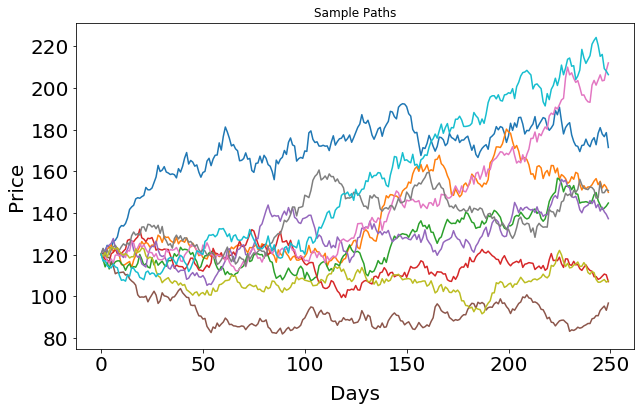

In [32]:
plt.figure(figsize=(10,6))
plt.plot(price_array[:,0:10])
plt.ylabel('Price', size = 20)
plt.xlabel('Days', size = 20, labelpad = 10)
plt.title("Sample Paths")
plt.tick_params(labelsize = 20)   

## Method 2: Using the Euler-Maruyama method

$S(t) = S(t-1) + S(t-1)*(\mu dt + \sigma Z(0,1) \sqrt{dt})$ 

Here, $dt$ is 1 day. We create an array which would be called "r_array_2" which is $\mu + \sigma Z(0,1)$.

In [12]:
r_array_2 = mu + sigma*np.random.normal(0,1,(t_intervals,t_iterations))

price_array_2 = np.zeros_like(r_array_2)

price_array_2[0] = S_0

In [13]:
for t in range(1, t_intervals):
    price_array_2[t] = price_array_2[t-1] + price_array_2[t-1]*r_array_2[t]

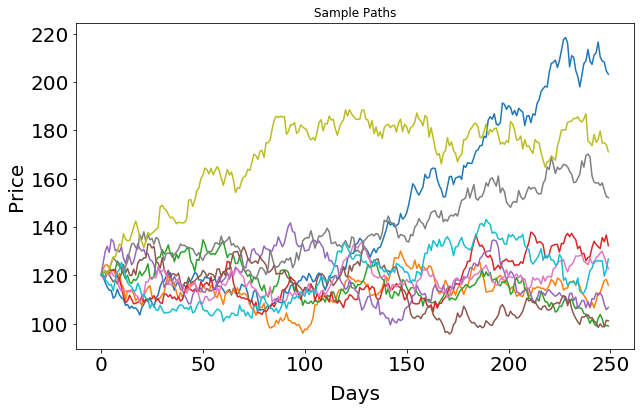

In [33]:
plt.figure(figsize=(10,6))
plt.plot(price_array_2[:,0:10])
plt.ylabel('Price', size = 20)
plt.xlabel('Days', size = 20, labelpad = 10)
plt.title("Sample Paths")
plt.tick_params(labelsize = 20)   

### Plotting the mean of the two solutions

In [20]:
analytic_mean = np.mean(price_array,axis=1)
sde_mean = np.mean(price_array_2, axis=1)

In [21]:
time_array = np.arange(0,250,1.0)
sol_mean = (S_0.values)*np.exp(0.00054357*time_array)

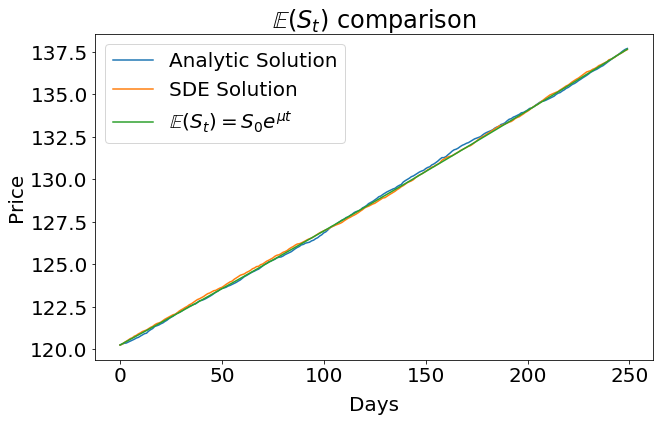

In [39]:
plt.figure(figsize=(10,6))
plt.plot(analytic_mean, label = "Analytic Solution")
plt.plot(sde_mean, label = "SDE Solution")
plt.plot(time_array,sol_mean,label='$\mathbb{E}(S_t) = S_0 e^{\mu t}$')
plt.ylabel('Price', size = 20)
plt.xlabel('Days', size = 20, labelpad = 10)
plt.tick_params(labelsize = 20)
plt.title("$\mathbb{E}(S_t)$ comparison", size = 24)
plt.legend(fontsize=20)

Thus the mean of the two solutions are equal. We would also check the mean of $log(S_t)$ and the variance in the next sections.

### Plotting the mean of the log and comparing it with the analytic solution

In [26]:
analytic_log = np.mean(np.log(price_array),axis=1)
sde_log = np.mean(np.log(price_array_2),axis=1)

sol_log_mean = np.log(S_0.values) + (0.00039621)*time_array

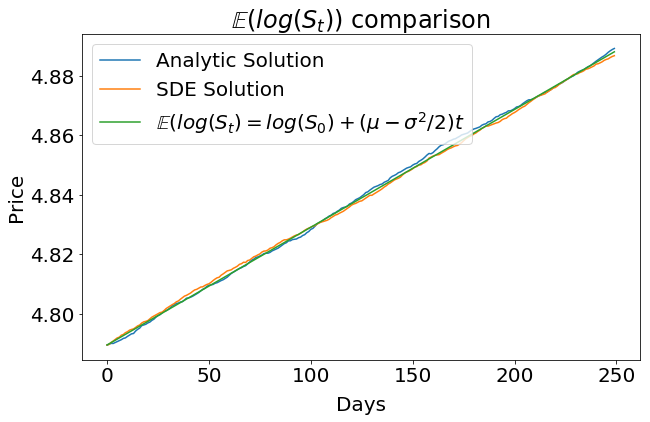

In [38]:
plt.figure(figsize=(10,6))
plt.plot(analytic_log, label = "Analytic Solution")
plt.plot(sde_log, label = "SDE Solution")
plt.plot(time_array,sol_log_mean,label='$\mathbb{E}(log (S_t) = log(S_0) + (\mu - \sigma^2/2)t$')
plt.ylabel('Price', size = 20)
plt.xlabel('Days', size = 20, labelpad = 10)
plt.tick_params(labelsize = 20)
plt.title("$\mathbb{E}(log(S_t))$ comparison", size = 24)
plt.legend(fontsize=20)

### Plotting and comparing the variance

In [29]:
analytic_var = np.var(price_array,axis=1)
sde_var = np.var(price_array_2, axis=1)

function_var = ((S_0.values)**2.0)*(np.exp(2.0*0.00054391*time_array))*(np.exp(0.01718703*0.01718703*time_array) - 1.0)

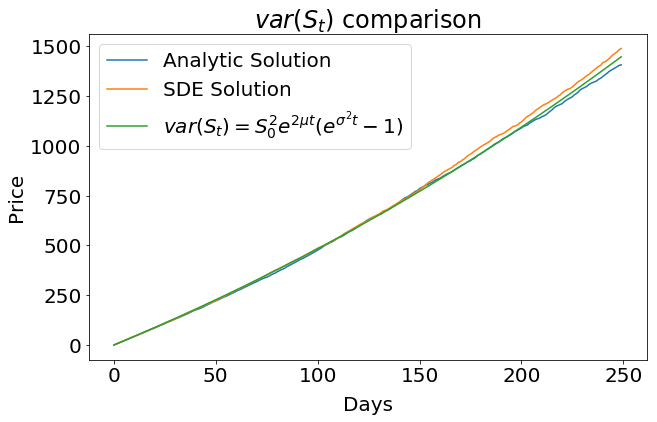

In [37]:
plt.figure(figsize=(10,6))
plt.plot(analytic_var, label = "Analytic Solution")
plt.plot(sde_var, label = "SDE Solution")
plt.plot(time_array,function_var,label='$var(S_t) = S_0^2 e^{2 \mu t} (e^{\sigma^2 t} - 1)$')
plt.ylabel('Price', size = 20)
plt.xlabel('Days', size = 20, labelpad = 10)
plt.tick_params(labelsize = 20)
plt.title("$var(S_t)$ comparison", size = 24)
plt.legend(fontsize=20)